In [29]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [30]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = r"C:\Users\user\Videos\belajar\Qml\PennyLane\_static\demonstration_assets_2"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

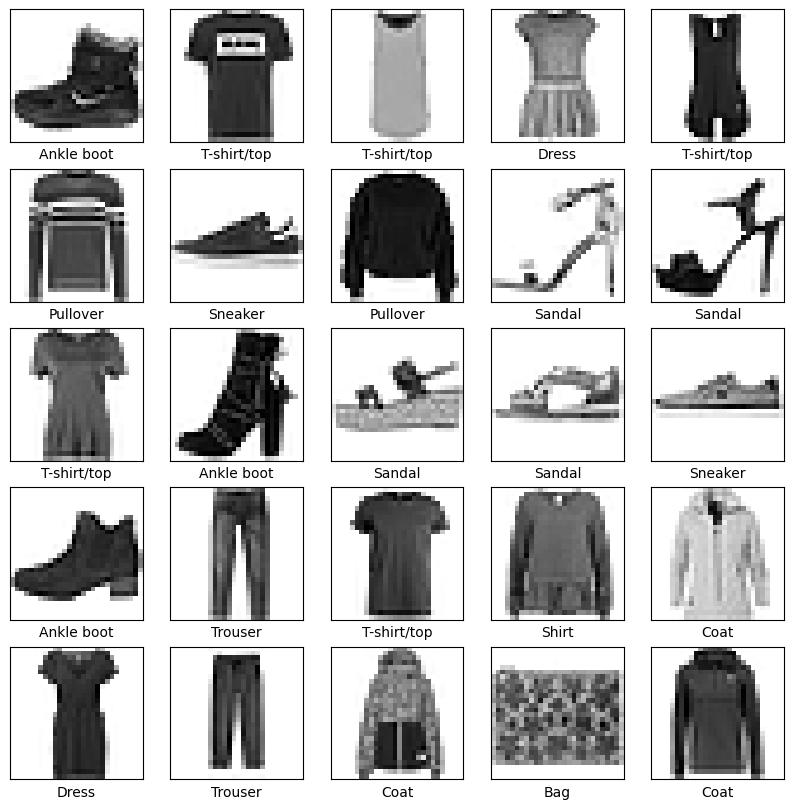

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Load Fashion-MNIST dataset
fmnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist_dataset.load_data()

# Tentukan jumlah data yang ingin digunakan
n_train = 60  # Ubah sesuai kebutuhan
n_test = 10   # Ubah sesuai kebutuhan

# Kurangi ukuran dataset jika perlu
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalisasi nilai piksel ke dalam rentang [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Tambahkan dimensi ekstra untuk saluran konvolusi (grayscale)
train_images = np.array(train_images[..., tf.newaxis])
test_images = np.array(test_images[..., tf.newaxis])

# 🔹 Tambahkan daftar nama kelas Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualisasi beberapa gambar dari dataset
plt.figure(figsize=(10, 10))
for i in range(25):  # Menampilkan 25 gambar pertama
    plt.subplot(5, 5, i + 1)
    plt.xticks([])  # Menghilangkan sumbu X
    plt.yticks([])  # Menghilangkan sumbu Y
    plt.grid(False)
    plt.imshow(train_images[i].squeeze(), cmap=plt.cm.binary)  # Menghapus dimensi ekstra sebelum ditampilkan
    plt.xlabel(class_names[train_labels[i]])  # Menampilkan label kelas

plt.show()


In [32]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [33]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [34]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
60/60        
Quantum pre-processing of test images:


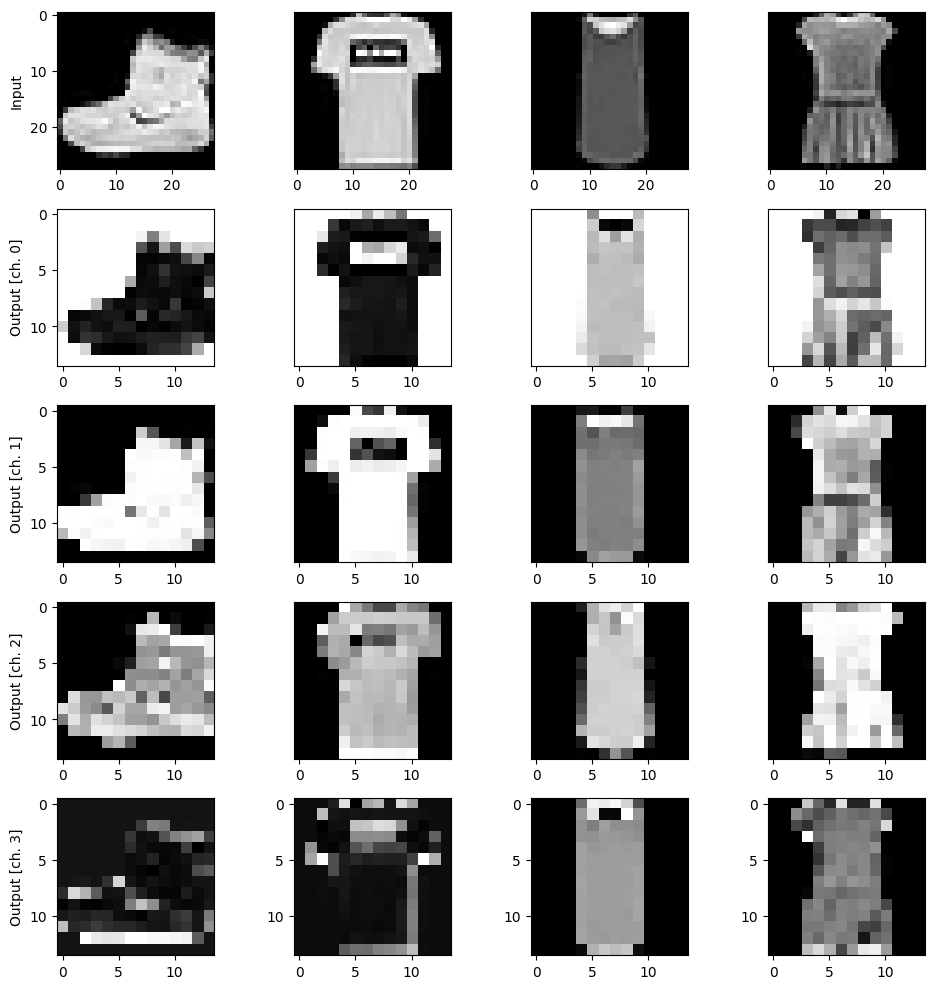

In [35]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [36]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [37]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
15/15 - 0s - 32ms/step - accuracy: 0.2333 - loss: 2.4134 - val_accuracy: 0.2000 - val_loss: 2.6370
Epoch 2/30
15/15 - 0s - 5ms/step - accuracy: 0.5167 - loss: 1.4203 - val_accuracy: 0.3000 - val_loss: 1.9700
Epoch 3/30
15/15 - 0s - 5ms/step - accuracy: 0.7500 - loss: 1.0636 - val_accuracy: 0.4000 - val_loss: 1.5403
Epoch 4/30
15/15 - 0s - 6ms/step - accuracy: 0.8500 - loss: 0.8219 - val_accuracy: 0.4000 - val_loss: 1.3672
Epoch 5/30
15/15 - 0s - 5ms/step - accuracy: 0.8667 - loss: 0.6595 - val_accuracy: 0.4000 - val_loss: 1.2586
Epoch 6/30
15/15 - 0s - 5ms/step - accuracy: 0.9000 - loss: 0.5468 - val_accuracy: 0.4000 - val_loss: 1.1675
Epoch 7/30
15/15 - 0s - 5ms/step - accuracy: 0.9333 - loss: 0.4623 - val_accuracy: 0.7000 - val_loss: 1.1076
Epoch 8/30
15/15 - 0s - 6ms/step - accuracy: 0.9333 - loss: 0.3970 - val_accuracy: 0.7000 - val_loss: 1.0610
Epoch 9/30
15/15 - 0s - 5ms/step - accuracy: 0.9333 - loss: 0.3453 - val_accuracy: 0.7000 - val_loss: 1.0216
Epoch 10/30
15/15 

In [38]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
15/15 - 0s - 27ms/step - accuracy: 0.1167 - loss: 2.3609 - val_accuracy: 0.0000e+00 - val_loss: 2.0606
Epoch 2/30
15/15 - 0s - 5ms/step - accuracy: 0.5000 - loss: 1.6343 - val_accuracy: 0.3000 - val_loss: 1.9054
Epoch 3/30
15/15 - 0s - 5ms/step - accuracy: 0.6167 - loss: 1.3300 - val_accuracy: 0.5000 - val_loss: 1.6611
Epoch 4/30
15/15 - 0s - 5ms/step - accuracy: 0.6833 - loss: 1.1194 - val_accuracy: 0.5000 - val_loss: 1.4554
Epoch 5/30
15/15 - 0s - 4ms/step - accuracy: 0.7667 - loss: 0.9778 - val_accuracy: 0.7000 - val_loss: 1.3125
Epoch 6/30
15/15 - 0s - 5ms/step - accuracy: 0.7667 - loss: 0.8732 - val_accuracy: 0.7000 - val_loss: 1.2087
Epoch 7/30
15/15 - 0s - 4ms/step - accuracy: 0.8000 - loss: 0.7890 - val_accuracy: 0.7000 - val_loss: 1.1230
Epoch 8/30
15/15 - 0s - 5ms/step - accuracy: 0.8500 - loss: 0.7194 - val_accuracy: 0.7000 - val_loss: 1.0504
Epoch 9/30
15/15 - 0s - 5ms/step - accuracy: 0.8667 - loss: 0.6611 - val_accuracy: 0.7000 - val_loss: 0.9896
Epoch 10/30
15

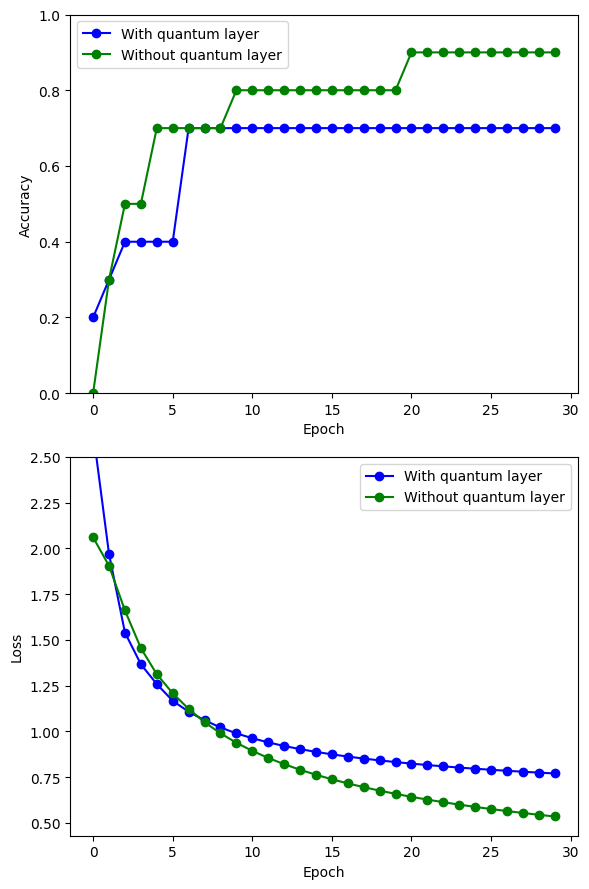

In [39]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()